<h1 style="color:red; text-align:center; text-decoration:underline;">Réseaux Siamois (Siamese Networks)</h1>


# Reconnaissance faciale à l’aide d’un réseau siamois
Dans ce projet, nous utilisons un **réseau siamois** pour apprendre à distinguer si deux visages appartiennent à la même personne ou non. Les données proviennent de la base de données ORL (AT&T), téléchargeable depuis : https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html. Chaque dossier contient 10 images d’un même individu sous différents angles. Pour constituer l’ensemble d’entraînement, nous formons des paires : les **paires similaires** proviennent du même dossier, et les **paires dissemblables** de dossiers différents. Chaque image est traitée par un **réseau convolutif partagé** qui extrait un vecteur de caractéristiques. La **distance euclidienne** entre les deux vecteurs permet ensuite de mesurer leur similarité. Le modèle est entraîné à minimiser cette distance pour les visages similaires et à l’augmenter dans le cas contraire.


Tout d’abord, nous allons importer les bibliothèques nécessaires.

![Siamese Network - Exemples de paires](Images/SiamNet.png)

*Illustration du fonctionnement du réseau siamois : les paires d'images en entrée sont comparées deux à deux. Les paires dites "Genuine" représentent des images de la même personne, tandis que les paires "Imposite" correspondent à des visages de personnes différentes. Le réseau apprend à distinguer ces deux cas à partir de la distance entre leurs vecteurs de caractéristiques.*


In [1]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

Nous définissons maintenant une fonction permettant de lire une image en entrée. La fonction `read_image` prend une image en paramètre et renvoie un tableau `numpy`.

In [4]:
def read_image(filename, byteorder='>'):
    
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract the header, width, height and maxval of the image


    header, width, height, maxval = re.search(
    rb"(P5\s(?:\s*#.*[\r\n]+)*)"
    rb"(\d+)\s+(\d+)\s+(\d+)[\r\n]+",
    buffer
).groups()

    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))




À titre d’exemple, ouvrons une image.  

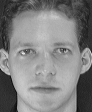

In [8]:
Image.open(r"C:\Users\Lenovo Thinkpad X1\Downloads\att_faces\s1\1.pgm")

Lorsque nous transmettons cette image à la fonction `read_image`, elle est convertie et renvoyée sous forme de tableau `numpy`.










In [13]:
img = read_image(r"C:\Users\Lenovo Thinkpad X1\Downloads\att_faces\s1\1.pgm")

In [14]:
img.shape

(112, 92)

Nous définissons maintenant une autre fonction, `get_data`, destinée à générer nos données. Comme nous le savons, pour le réseau siamois, les données doivent être structurées sous forme de paires (similaires et dissemblables) avec un label binaire.

Nous commençons par lire deux images (`img1`, `img2`) provenant du même dossier, que nous stockons dans le tableau `x_genuine_pair`, en attribuant l’étiquette `y_genuine = 1`. Ensuite, nous lisons deux images provenant de dossiers différents, que nous stockons dans `x_imposite_pair`, avec l’étiquette `y_imposite = 0`.

Enfin, nous concaténons les tableaux `x_genuine_pair` et `x_imposite_pair` pour former `X`, et les étiquettes `y_genuine` et `y_imposite` pour former `Y`.


In [17]:
size = 2
total_sample_size = 10000

def get_data(size, total_sample_size):
    base_path = r"C:\Users\Lenovo Thinkpad X1\Downloads\att_faces"

    # read the image
    image = read_image(base_path + r'\s1\1.pgm', 'rw+')
    image = image[::size, ::size]
    
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            img1 = read_image(f"{base_path}\\s{i+1}\\{ind1+1}.pgm", 'rw+')
            img2 = read_image(f"{base_path}\\s{i+1}\\{ind2+1}.pgm", 'rw+')
            
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
            
            img1 = read_image(f"{base_path}\\s{ind1+1}\\{j+1}.pgm", 'rw+')
            img2 = read_image(f"{base_path}\\s{ind2+1}\\{j+1}.pgm", 'rw+')
            
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            
            y_imposite[count] = 0
            count += 1
    
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y


Nous générons maintenant nos données et vérifions leur taille. Comme on peut le constater, nous disposons de 20 000 paires d’images : parmi elles, 10 000 sont des paires similaires (genuine) et 10 000 sont des paires dissemblables (imposite).


In [18]:
X, Y = get_data(size, total_sample_size)

In [19]:
X.shape

(20000, 2, 1, 56, 46)

In [21]:
Y.shape

(20000, 1)

Ensuite, nous divisons nos données en deux ensembles : 75 % pour l'entraînement et 25 % pour le test.


In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

Maintenant que nous avons généré nos données, nous construisons notre réseau siamois. Nous commençons par définir le **réseau de base**, qui est essentiellement un réseau convolutif utilisé pour l'extraction des caractéristiques. Il est composé de deux couches convolutives avec des fonctions d’activation ReLU, suivies de couches de max pooling, puis d’une couche d’aplatissement (flatten).


In [74]:
from keras.layers import Input, Lambda
from keras.models import Model

import tensorflow.keras.backend as K

from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense

def build_base_network(input_shape):
    seq = Sequential()

    nb_filter = [6, 12]
    kernel_size = (3, 3)

    # Convolutional Layer 1
    seq.add(Conv2D(nb_filter[0], kernel_size=kernel_size, padding='valid',
                   input_shape=input_shape, data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
    seq.add(Dropout(0.25))

    # Convolutional Layer 2
    seq.add(Conv2D(nb_filter[1], kernel_size=kernel_size, padding='valid',
                   data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
    seq.add(Dropout(0.25))

    # Fully Connected Layers
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))

    return seq


Ensuite, nous faisons passer chaque paire d’images dans le réseau de base, qui renverra les **embeddings**, c’est-à-dire les vecteurs de caractéristiques.


In [76]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

In [77]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

Les vecteurs `feat_vecs_a` et `feat_vecs_b` représentent les vecteurs de caractéristiques de notre paire d’images. Nous les transmettons ensuite à la **fonction d’énergie** pour calculer la distance entre eux. Dans notre cas, nous utilisons la **distance euclidienne** comme mesure de cette distance.


In [78]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [79]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

Nous fixons ensuite le nombre d’époques à 13, utilisons l’optimiseur RMSprop, et définissons notre modèle.


In [80]:
epochs = 13
rms = RMSprop()

In [81]:
model = Model(inputs=[img_a, img_b], outputs=distance)


Ensuite, nous définissons notre fonction de perte comme étant la fonction `contrastive_loss` et compilons le modèle.


In [82]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [83]:
model.compile(loss=contrastive_loss, optimizer=rms)

In [84]:
img_1 = x_train[:, 0]
img2 = x_train[:, 1]

In [85]:
model.fit([img_1, img2], y_train, validation_split=0.25,
          batch_size=128, verbose=2, epochs=epochs)

Epoch 1/13
88/88 - 81s - 917ms/step - loss: 0.2557 - val_loss: 0.2921
Epoch 2/13
88/88 - 85s - 962ms/step - loss: 0.1646 - val_loss: 0.2527
Epoch 3/13
88/88 - 87s - 990ms/step - loss: 0.1339 - val_loss: 0.1921
Epoch 4/13
88/88 - 84s - 956ms/step - loss: 0.1156 - val_loss: 0.1473
Epoch 5/13
88/88 - 84s - 957ms/step - loss: 0.1009 - val_loss: 0.1125
Epoch 6/13
88/88 - 660s - 8s/step - loss: 0.0890 - val_loss: 0.1044
Epoch 7/13
88/88 - 89s - 1s/step - loss: 0.0791 - val_loss: 0.0686
Epoch 8/13
88/88 - 85s - 961ms/step - loss: 0.0731 - val_loss: 0.0650
Epoch 9/13
88/88 - 89s - 1s/step - loss: 0.0662 - val_loss: 0.0675
Epoch 10/13
88/88 - 99s - 1s/step - loss: 0.0611 - val_loss: 0.0591
Epoch 11/13
88/88 - 90s - 1s/step - loss: 0.0569 - val_loss: 0.0401
Epoch 12/13
88/88 - 97s - 1s/step - loss: 0.0533 - val_loss: 0.0472
Epoch 13/13
88/88 - 95s - 1s/step - loss: 0.0499 - val_loss: 0.0388


Nous effectuons maintenant des prédictions à l’aide des données de test.


In [86]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 147ms/step


In [87]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

Enfin, nous évaluons la précision de notre modèle.


In [88]:
compute_accuracy(pred, y_test)

0.9278810408921933

<h3 style="color:#0056b3; text-decoration:underline;">Résultat et Interprétation</h3>

Ce projet met en œuvre un <strong>réseau siamois (Siamese Network)</strong> pour des tâches de reconnaissance de similarité, en particulier la reconnaissance faciale à partir de la base de données ORL (AT&T) et la classification d’images manuscrites MNIST.  
L’objectif de cette architecture est de mesurer la <strong>similarité entre deux entrées</strong> à partir de leurs caractéristiques apprises via un <strong>réseau convolutif partagé</strong>. Chaque image passe par une même architecture de neurones convolutifs, produisant un vecteur d’embedding qui résume son contenu visuel.

Les vecteurs obtenus sont comparés par une <strong>distance euclidienne</strong>, servant à quantifier la proximité entre les paires d’images. Le modèle est entraîné à l’aide d’une <strong>fonction de perte contrastive (contrastive loss)</strong>, qui pousse les paires similaires (même classe ou même personne) à se rapprocher dans l’espace latent, et les paires différentes à s’éloigner au-delà d’un seuil défini.

Les visualisations expérimentales montrent une <strong>séparation nette</strong> entre les distances des paires similaires et non similaires, témoignant d’une capacité à généraliser la notion de similarité, même sur des données bruitées ou complexes.

Le réseau a atteint une <strong>précision de 92,58 %</strong> sur l’ensemble de test de l’expérience, ce qui confirme la bonne convergence de l’apprentissage et la qualité de l’espace métrique appris.  
Ces performances illustrent l’efficacité des réseaux siamois pour des scénarios de <strong>reconnaissance avec peu d’exemples (few-shot learning)</strong>, comme la vérification d’identité, la détection de doublons ou la vérification de signature.

En résumé, les réseaux siamois constituent une solution robuste pour l’<strong>apprentissage métrique</strong>, capable de généraliser efficacement en se basant non pas sur la catégorisation directe, mais sur les relations entre les exemples étudiés.
